In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [128]:
# Generate non-linear data
def generate_2d_sinusoidal_data(N, M, num_samples):
    data = []
    for _ in range(num_samples):
        x = np.linspace(0, 1, N)
        y = np.linspace(0, 1, M)
        xx, yy = np.meshgrid(x, y)

        # Random phase shifts for x and y directions
        phase_shift_x = np.random.uniform(0, 2 * np.pi)
        phase_shift_y = np.random.uniform(0, 2 * np.pi)

        # Random frequency multipliers for x and y directions
        freq_multiplier_x = np.random.uniform(0.5, 1.5)
        freq_multiplier_y = np.random.uniform(0.5, 1.5)

        # Generate sinusoidal data with random phase and frequency
        z = np.sin(2 * np.pi * freq_multiplier_x * xx + phase_shift_x) * np.cos(
            2 * np.pi * freq_multiplier_y * yy + phase_shift_y)
        data.append(z)

    return np.array(data).astype(np.float32)

In [129]:
class DenseAutoEncoder(nn.Module):
    """
    Base autoencoder neural principal latent components decomposition model.
    """

    def __init__(self, input_dim: int | list | tuple, latent_dim: int, hidden_dim: int | list | tuple, num_layers=3,
                 act_fn=nn.Mish):
        super().__init__()
        # check if input_dim is instance of iterable in such a case take the first argument only
        if isinstance(input_dim, (list, tuple)):
            input_dim = input_dim[0]

        self.latent_dim = latent_dim
        layers_encoder = []
        if not isinstance(hidden_dim, (list, tuple)):
            hidden_dim = [hidden_dim] * num_layers
        elif len(hidden_dim) != num_layers:
            warnings.warn("The hidden_dim is an iterable, the length of hidden_dim must be equal to num_layers."
                          " Setting it to [hidden_dim] * num_layers.")
            num_layers = len(hidden_dim)

        assert len(hidden_dim) == num_layers, "The length of hidden_dim must be equal to num_layers."

        layer = nn.Linear(input_dim, hidden_dim[0])       

        layers_encoder.append(layer)
        layers_encoder.append(act_fn())
        for i in range(1, num_layers):
            layer = nn.Linear(hidden_dim[i - 1], hidden_dim[i])                      
            layers_encoder.append(layer)           
            layers_encoder.append(act_fn())

        layer = nn.Linear(hidden_dim[-1], latent_dim)       
        layers_encoder.append(layer)

        self.encoder = nn.Sequential(*layers_encoder)

        layers_decoder = []
        reversed_hidden_dim = hidden_dim[::-1]
        layer = nn.Linear(latent_dim, reversed_hidden_dim[0])       

        layers_decoder.append(layer)      
        for i in range(1, num_layers):
            layer = nn.Linear(reversed_hidden_dim[i - 1], reversed_hidden_dim[i])                      
            layers_decoder.append(layer)                     

        layer = nn.Linear(reversed_hidden_dim[-1], input_dim)       
        layers_decoder.append(layer)
        self.decoder = nn.Sequential(*layers_decoder)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction
        

In [130]:
N, M = 30, 30
data = generate_2d_sinusoidal_data(N, M, 1000)
data = np.squeeze(data.reshape(data.shape[0], -1))
data.shape

(1000, 900)

In [131]:
# Convert to PyTorch tensors
x_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(data, dtype=torch.float32)
x_tensor.shape, y_tensor.shape

(torch.Size([1000, 900]), torch.Size([1000, 900]))

In [132]:
# Initialize model, criterion, and optimizer
model = DenseAutoEncoder(input_dim=x_tensor.shape[1:], latent_dim=30, hidden_dim=[512,256,128,64,32], num_layers=5, act_fn=nn.SiLU)
model

DenseAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=900, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): SiLU()
    (10): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=900, bias=True)
  )
)

In [133]:
device = torch.device("cuda")
model.to(device)
x_tensor = x_tensor.to(device)

In [134]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 10000
epoch_progress = tqdm(range(num_epochs), desc="epoch", leave=True, total=num_epochs)        
for epoch in epoch_progress:
    model.train()
    optimizer.zero_grad()
    reconstructed = model(x_tensor)
    loss = criterion(reconstructed, x_tensor)
    loss.backward()
    optimizer.step()    
    epoch_progress.set_postfix({"reconstruction_loss": loss.item()})

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

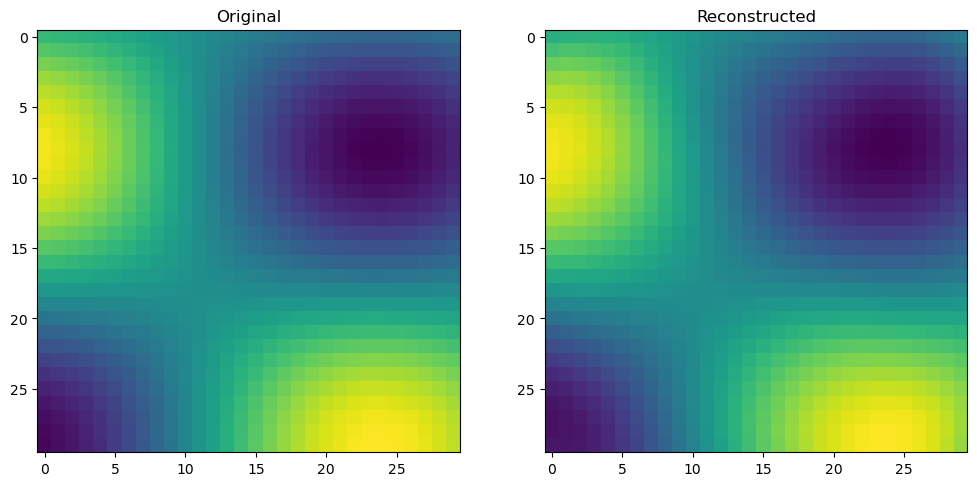

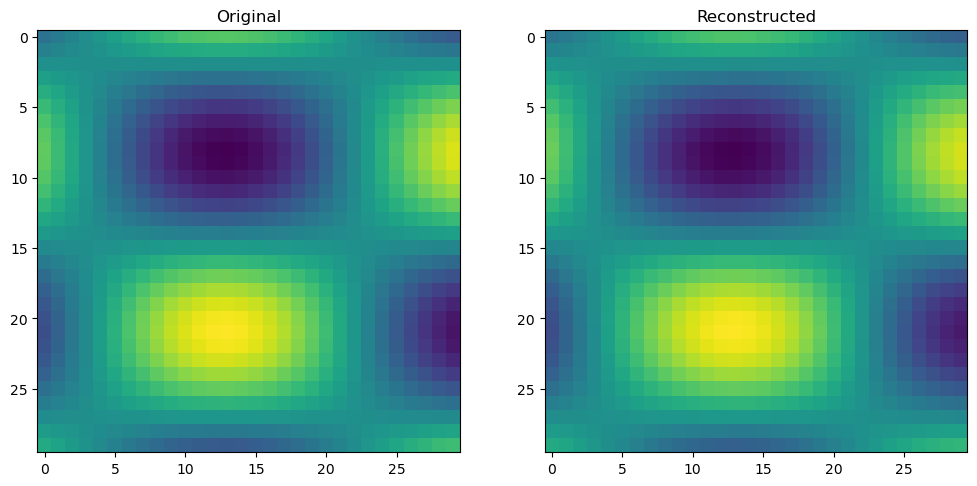

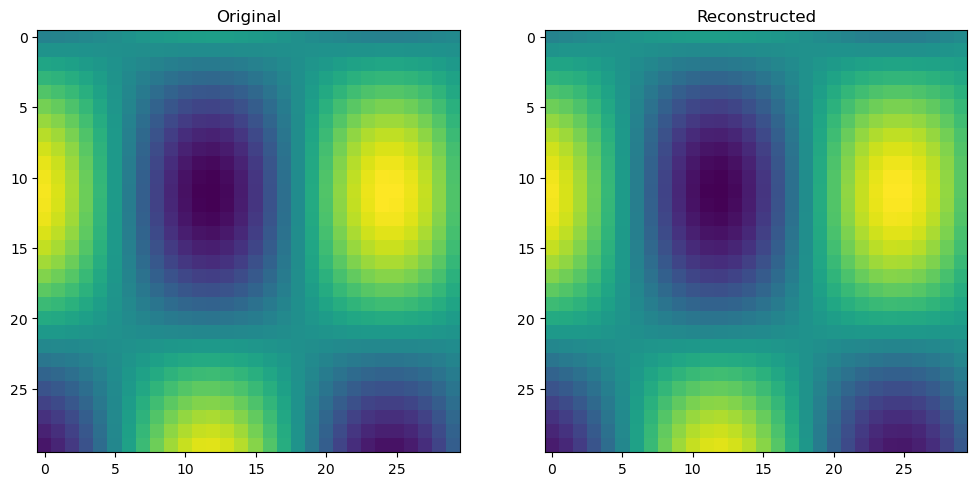

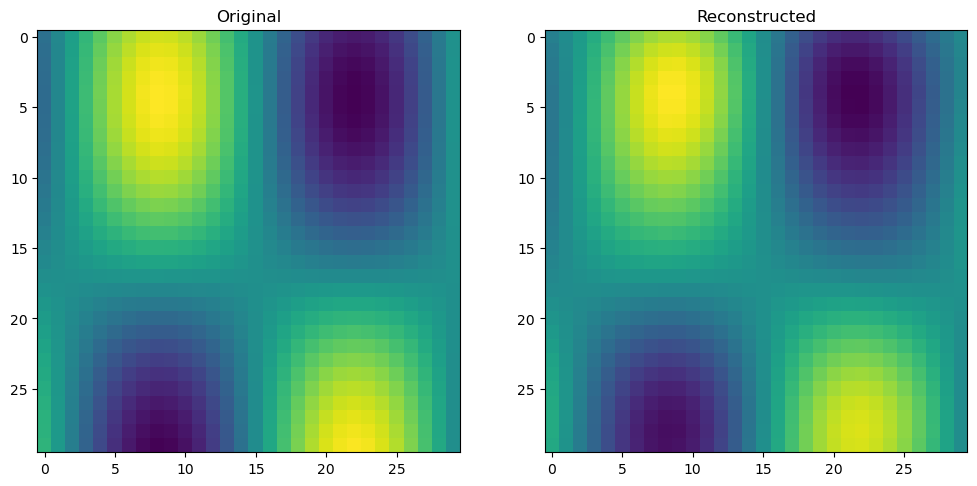

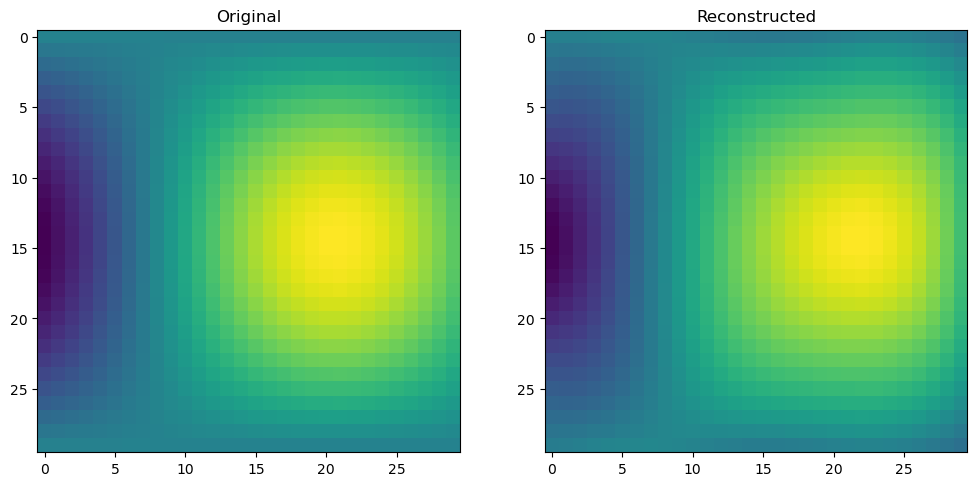

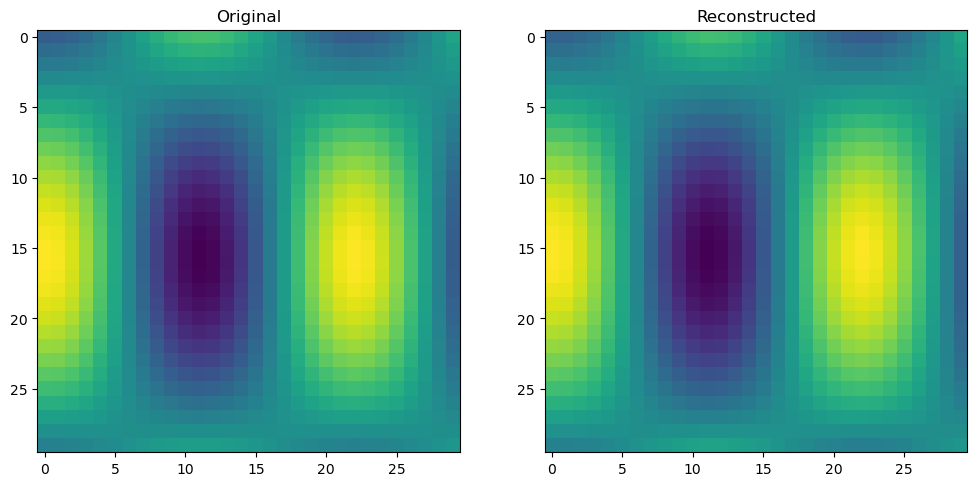

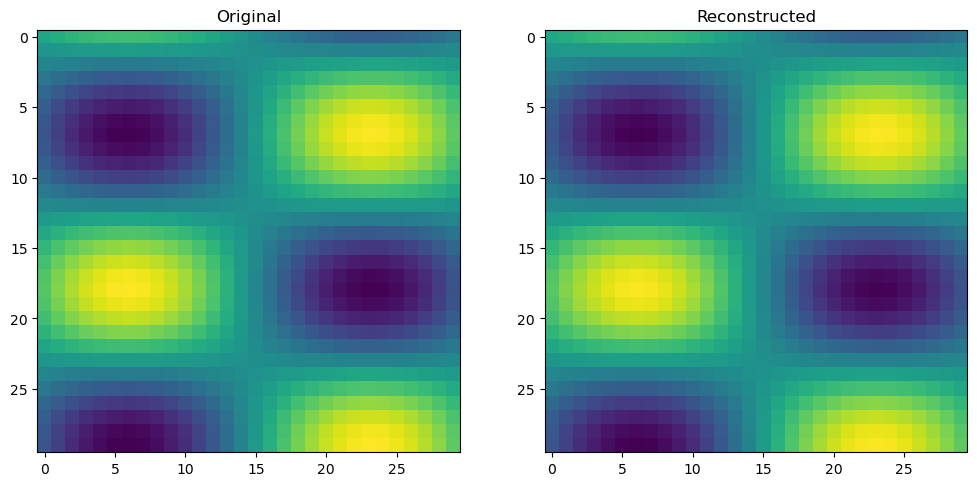

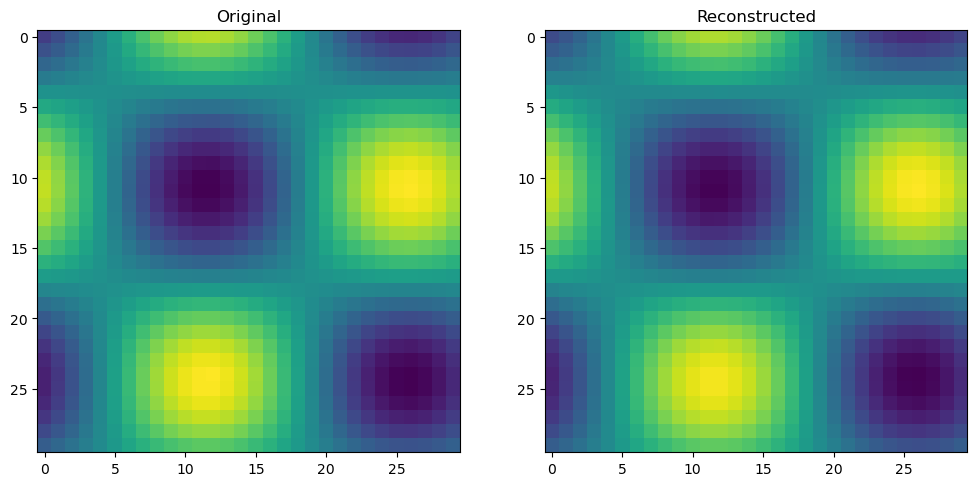

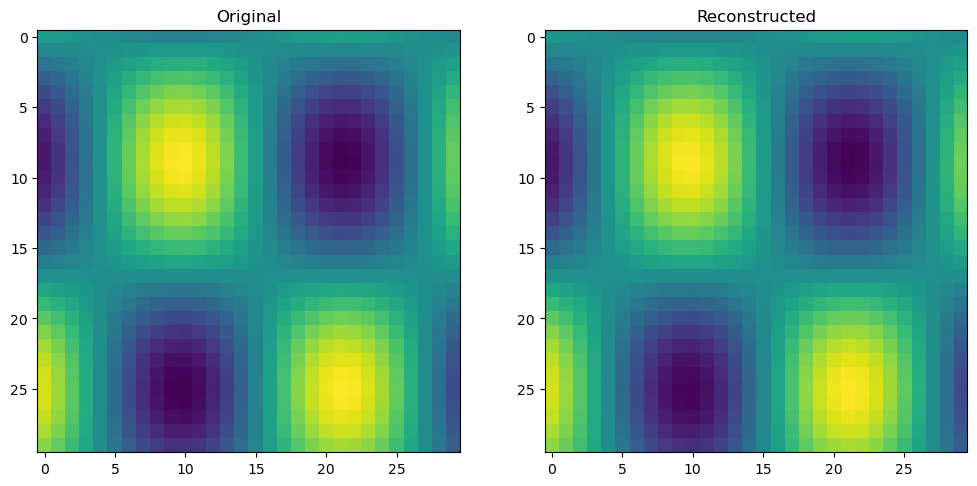

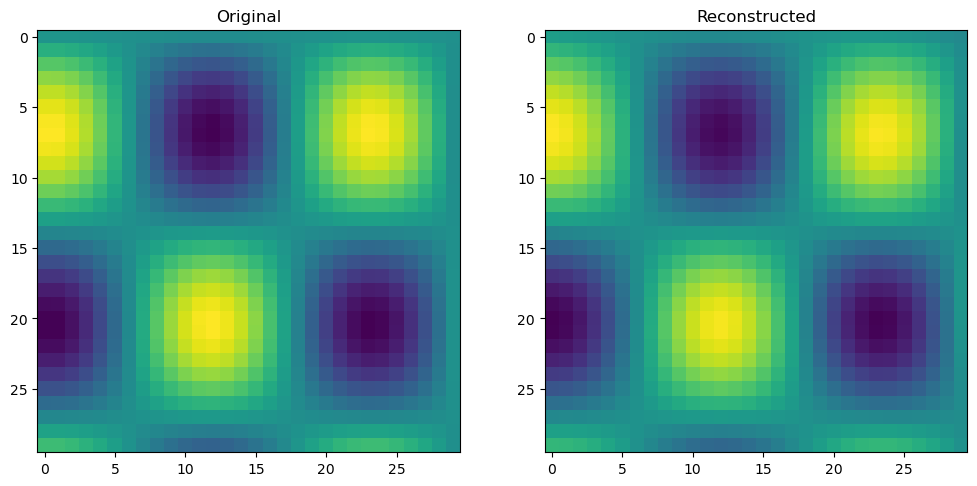

In [140]:
for i in range(10):
    # Plot original and reconstructed signals for a sample
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(data[i].reshape(N,N), cmap="viridis")
    axes[0].set_title("Original")
    axes[1].imshow(model(x_tensor[i]).detach().cpu().numpy().reshape(N,M), cmap="viridis")
    axes[1].set_title("Reconstructed")
    plt.show()

In [141]:
def get_test_data(model, test_data, num_samples):
    """
    Prepare test data for linear mapping property evaluation.
    
    Args:
    model: The encoder model to be tested.
    test_data: The original test dataset.
    num_samples: Number of samples to use for testing.
    
    Returns:
    x, y: Encoded test samples.
    """
    model.eval()
    num_samples = min(test_data.shape[0], num_samples)
    indices = np.random.choice(test_data.shape[0], num_samples, replace=False)
    x_samples = test_data[indices]
    y_samples = test_data[np.random.choice(test_data.shape[0], num_samples, replace=False)]
    
    with torch.no_grad():
        x = model(x_samples)
        y = model(y_samples)
    
    return x, y

In [142]:
def evaluate_and_plot(model, x, y):
    """
    Evaluate linear mapping properties and plot results.
    
    Args:
    model: The decoder model to be tested.
    x, y: Encoded test samples.
    
    Returns:
    additivity_corr, homogeneity_corr: Correlation coefficients for additivity and homogeneity.
    """
    model.eval()   
    num_samples = x.shape[0]
    
    def f(x):
        return model(x).detach().cpu().numpy().flatten()
    
    with torch.no_grad():
        # Generate alpha values between -2 and 2
        alpha = (4.0 * torch.rand(size=(num_samples,), device=x.device)) - 2
        
        f_x = f(x)
        f_y = f(y)
        f_x_plus_y = f(x + y)
        f_alpha_x = f(alpha.unsqueeze(1) * x)  # Unsqueeze alpha to match x's dimensions
        
        alpha_np = alpha.cpu().numpy()
        
        # Ensure all arrays have the same length
        min_length = min(len(f_x), len(f_y), len(f_x_plus_y), len(f_alpha_x), len(alpha_np))
        f_x = f_x[:min_length]
        f_y = f_y[:min_length]
        f_x_plus_y = f_x_plus_y[:min_length]
        f_alpha_x = f_alpha_x[:min_length]
        alpha_np = alpha_np[:min_length]
        
        # Calculate correlation coefficients
        additivity_corr = np.corrcoef(f_x_plus_y, f_x + f_y)[0, 1]
        homogeneity_corr = np.corrcoef(f_alpha_x, alpha_np * f_x)[0, 1]
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Additivity plot
    ax1.scatter(f_x_plus_y, f_x + f_y, color="blue", alpha=0.5, s=1)
    min_val = min(f_x_plus_y.min(), (f_x + f_y).min())
    max_val = max(f_x_plus_y.max(), (f_x + f_y).max())
    ax1.plot([min_val, max_val], [min_val, max_val], "k--", lw=2)
    ax1.set_xlabel(r"$f(x + y)$")
    ax1.set_ylabel(r"$f(x) + f(y)$")
    ax1.set_title(f"Additivity\nCorrelation: {additivity_corr:.4f}")
    
    # Homogeneity plot
    scatter = ax2.scatter(f_alpha_x, alpha_np * f_x, c=alpha_np, cmap='coolwarm', alpha=0.7, s=3)
    min_val = min(f_alpha_x.min(), (alpha_np * f_x).min())
    max_val = max(f_alpha_x.max(), (alpha_np * f_x).max())
    ax2.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)
    ax2.set_xlabel(r"$f(\alpha x)$")
    ax2.set_ylabel(r"$\alpha f(x)$")
    ax2.set_title(f"Homogeneity\nOverall Correlation: {homogeneity_corr:.4f}")
    
    # Add colorbar for alpha values
    cbar = fig.colorbar(scatter, ax=ax2)
    cbar.set_label('Alpha values')
    
    # Add horizontal and vertical lines at 0
    ax2.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
    ax2.axvline(x=0, color='k', linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    return additivity_corr, homogeneity_corr

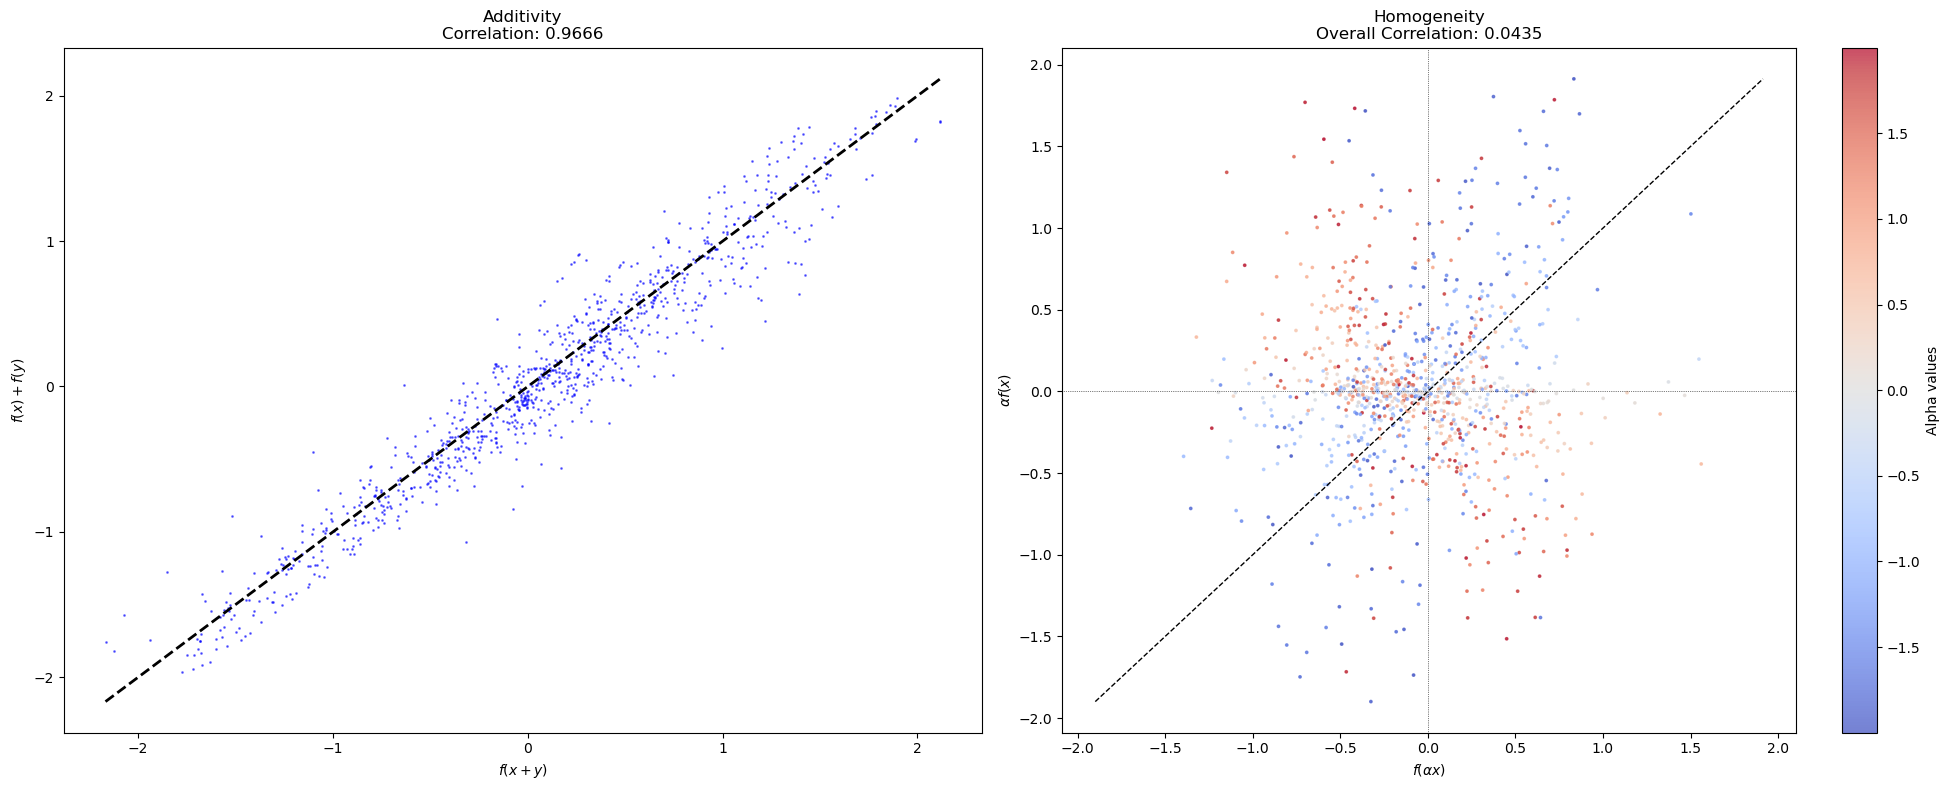

In [143]:
# Usage example:
x, y = get_test_data(model.encoder, x_tensor, num_samples=1000)
additivity_corr, homogeneity_corr = evaluate_and_plot(model.decoder, x, y)